# Trainer と 拡張機能

[前章](https://pfn-chainer-tutorial-staging.appspot.com/ja/15_Advanced_Usage_of_Chainer_ja.html)までは、訓練ループを Python の `while` 文を使って記述してきました。しかし、ミニバッチをイテレータから取り出し、順伝播、損失、逆伝播をそれぞれ計算しネットワークのパラメータに反映する処理は定型的なものになりがちです。そういった定型的な処理をまとめたものが `Trainer` です。

`Trainer` には拡張機能が用意されており、訓練曲線の可視化や、訓練の途中状態やログの保存など、付加的な処理を簡単に追加することができます。


## `Trainer` の使用方法

### `Trainer` の概要

下図は `Trainer` に関連するオブジェクトの関係図です。  

![Trainerに関連するオブジェクト間の関係図](images/14/14_01.png)

それぞれの役割は以下のようになっています。  

- **データセット** (Dataset) は訓練や検証に使用するためのデータの集合です。
-  **イテレータ** (Iterator) はデータセットの一部をミニバッチとして切り出します。
- **モデル** (Model) はパラメータを保持し、ミニバッチを入力として損失を計算します。
- **オプティマイザ** (Optimizer) は最適化の手法を選択し、モデルのパラメータの更新を行います。代表的なものに `SGD` や `MomentumSGD`、`Adam` などがあります。
- **アップデータ** (Updater) はイテレータ・オプティマイザを統括し、順伝播・損失計算・逆伝播・パラメータの更新（オプティマイザの呼び出し）という、訓練ループ内の定型的な処理を実行します。
- **`Trainer`** クラスはアップデータを受け取り、訓練全体の管理を行います。具体的には、ミニバッチのループ処理や、訓練終了タイミングの決定、設定された拡張機能の呼び出しなどを行います。
- `Trainer` は、付加的な機能を**拡張機能**（extension）として設定することができます。よく利用される拡張機能は、訓練の途中結果の保存や、検証用データセットによる訓練途中での性能の検証、訓練進捗の可視化などです。

次に、それぞれの役割をもったオブジェクトを順番に準備します。

まず、本章で利用するパッケージをいくつか予めインポートしておきます。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import chainer
import chainer.links as L
import chainer.functions as F

### データセットの準備

ここでは scikit-learn の標準機能で用意されているデータセットのうち、[Chainer の基礎](https://pfn-chainer-tutorial-staging.appspot.com/ja/14_Basics_of_Chainer_ja.html)の章でも利用した Iris というデータセットを使用します。これは、アヤメ科の植物のうち 3 種（Setosa、Versicolour、Virginica）のサンプル 150 個について、花弁の長さの幅、がく片（花弁の付け根にある緑の葉のようなもの）の長さと幅を測ってデータとしたものです。

ここでは、各データを見てそれが 3 種類の植物のうちどれに属するのかを予測します。

まず、[Step 1 の改善: データセットの準備の工夫](Step-1-の改善:-データセットの準備の工夫)と同じようにデータセットを読み、`TupleDataset` を利用してデータセットオブジェクトを用意します

In [2]:
from sklearn.datasets import load_iris
dataset = load_iris()
x = dataset.data
t = dataset.target
x = np.array(x, np.float32)
t = np.array(t, np.int32)

In [3]:
from chainer.datasets import TupleDataset
dataset = TupleDataset(x, t)

本章では訓練と検証データのみ使用するため、テストデータは準備しません。データセットの 7 割を訓練用とし、残りの 3 割を検証用にします。

In [4]:
from chainer.datasets import split_dataset_random
n_train = int(len(dataset)*0.7)
train, valid = split_dataset_random(dataset, n_train, seed=0)
len(train), len(valid)

(105, 45)

Iris のデータセット 150 件のうち、105 件があらためて訓練用のデータセットとして取り出されました。残りの 45 件を検証用のデータとして使います。

### イテレータの準備

[SerialIterator](https://pfn-chainer-tutorial-staging.appspot.com/ja/15_Advanced_Usage_of_Chainer_ja.html#SerialIterator)と同様に、訓練データと検証データそれぞれに対してイテレータを作成します。

In [5]:
from chainer import iterators
batchsize = 32

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(valid, batchsize, shuffle=False, repeat=False)

### ネットワークの準備

[Step-2-の改善:-ネットワーク構造の工夫](https://pfn-chainer-tutorial-staging.appspot.com/ja/15_Advanced_Usage_of_Chainer_ja.html#Step-2-の改善:-ネットワーク構造の工夫)と同じように `Chain` を使って3 層のMLP（multilayer perceptron, 多層パーセプトロン）を用意します。

In [6]:
class MLP(chainer.Chain):

    def __init__(self, n_mid_units=10, n_out=3):
        super().__init__()

        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units)
            self.fc2 = L.Linear(n_mid_units, n_mid_units)
            self.fc3 = L.Linear(n_mid_units, n_out)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = self.fc3(h)
        return h

### アップデータの準備

訓練ループを自分で書く場合、各イテレーションでは
 
 - データセットからミニバッチを作成
 - 順伝播（forward）の計算
 - 損失（loss）の計算
 - 誤差逆伝播（backward）の計算
 - オプティマイザによってパラメータを更新
 
という一連のステップを実行します。これまでは、これは以下のように書いていました。


```python
train_batch = train_iter.next()
x, t = concat_examples(train_batch)

# ミニバッチのデータを使った予測値の計算
y = net(x)

# 予測値と正解データから損失を計算
loss = F.softmax_cross_entropy(y, t)

# 損失からの誤差逆伝播による勾配の計算
net.cleargrads()
loss.backward()

# 勾配を使ってモデル内のパラメータを更新
optimizer.update()
```

Chainer の機能として提供されているアップデータを用いることで、これらの一連の処理を簡単に書けるようになります。  

アップデータには、訓練のイテレーションを実行するのに必要なイテレータとオプティマイザを渡します。  

- イテレータはデータセットを持っています。データセットからバッチサイズの数だけサンプルを取り出し、ミニバッチにまとめます。
- オプティマイザは最適化対象のネットワークを持っています。それを使って順伝播と逆伝播を計算し、パラメータを更新します。  

早速、アップデータオブジェクトを作成してみましょう。

In [7]:
from chainer import optimizers
from chainer import training

# ネットワークを L.Classifier で包んで，損失の計算などをモデルに含める
net = L.Classifier(MLP())

# 最適化手法を選択してオプティマイザを作成し、最適化対象のネットワークを持たせる
optimizer = optimizers.SGD(lr=0.01).setup(net)

# アップデータにイテレータとオプティマイザを渡す
updater = training.StandardUpdater(train_iter, optimizer, device=-1) # device=-1でCPUでの計算実行を指定


`MLP` は、データを入力して予測値を計算するネットワークでした。これに損失計算を行う機能を簡単に追加するために、`L.Classifier` を使います。
`L.Classifier` は、データ `x` に加えて正解ラベル `t` も入力にとります。そして、`x` を `MLP` （`predictor` と呼びます）に渡して予測値を計算し、`t` と比較して損失値を返します。今回利用する目的関数は `L.Classifier` にデフォルトで設定されているソフトマックス交差エントロピー（`F.softmax_cross_entropy`）です。

`StandardUpdater` は、複数あるアップデータの実装のうち、最もシンプルなものです。他にも、複数の GPU を用いるための `MultiprocessParallelUpdater` があります。

GPU を用いた計算方法は[Step 5 の改善：ネットワークの訓練における工夫](https://pfn-chainer-tutorial-staging.appspot.com/ja/15_Advanced_Usage_of_Chainer_ja.html#Step-5-の改善：ネットワークの訓練における工夫)を参照してください。


### `Trainer` の作成と終了タイミングの指定

`Trainer`は、アップデータを通して実際にイテレーションを繰り返し実行しています。その繰り返しの終了タイミングは、 `Trainer` の作成時にコンストラクタに対して引数に `(整数, 単位)` というタプルを渡して指定します。 単位には `'iteration'` もしくは `'epoch'` のいずれかの文字列を指定します。1 イテレーション（iteration）とはミニバッチ 1 個分を処理することを表し、1 エポック（epoch）とは、イテレーションを繰り返してデータセット全体を 1 周することを表します。

例えば、 `(100, 'epoch')` のように指定すると、`Trainer` は 100 エポックで訓練を終了します。
`(100, 'iteration')` と指定すると、100 イテレーション後に訓練を終了します。

`Trainer`を作るときにこの引数（`stop_trigger`）を指定しないと、訓練は自動的には止まらず、永久にループが回り続けます。

では、実際に 10 エポック分のループを実行したら停止する `Trainer` オブジェクトを作成します。1 つ目の引数にループ内の処理を実行するアップデータを渡し、2 つ目に停止条件を表すタプルを指定しています。

In [8]:
trainer = training.Trainer(updater, (10, 'epoch'), out='results/iris_result1')

`out` 引数は、各種データを保存するときのディレクトリを指定しています。ディレクトリがない場合は自動的に作成します。主に、この次に説明する拡張機能で使われます。たとえば、訓練のログ、訓練中のモデル、損失の変化のグラフの画像ファイルなどを保存します。

### 拡張機能

拡張機能を使うと、`Trainer` に機能を追加することができます。

たとえば、訓練は `trainer.run()` で実行しますが、データセットやモデルによっては、完了までに数時間、数日、あるいは数か月ととても長い時間を要します。このとき、「`PrintReport`」などの拡張機能を利用することによって途中経過を画面に表示し、訓練の進行を確認することができます。

また、「`snapshot`」拡張機能を使えば、定期的にファイルにモデルや状態を保存することによって、不意に訓練が異常終了したときに備えることができます。

よく使われる代表的な拡張機能には、次のようなものがあります。

- `LogReport`: ログを自動的にファイルに保存する
- `PrintReport`: ターミナルに損失などの情報を表示する
- `PlotReport`: 損失をグラフで画像として保存する
- `snapshot`: 定期的に `Trainer` の状態を自動で保存する
- `ProgressBar`: 訓練の進捗をプログレスバーで表示する
- `dump_graph`: モデルのネットワーク構造を Graphviz 形式で保存
- `ParameterStatistics`: ネットワークのパラメータの平均や分散などの統計情報を出力

拡張機能は必要に応じて自分で作成することもできます。

拡張機能を`trainer` に設定するためには `trainer.extend()` というメソッドを使います。

In [9]:
from chainer.training import extensions

trainer.extend(extensions.LogReport(trigger=(1, 'epoch'), log_name='log'))
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(valid_iter, net, device=-1), name='val')
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'fc1/W/data/mean', 'elapsed_time']))
trainer.extend(extensions.ParameterStatistics(net.predictor.fc1, {'mean': np.mean}, report_grads=True))
trainer.extend(extensions.PlotReport(['fc1/W/grad/mean'], x_key='epoch', file_name='mean.png'))
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

ここに挙げた拡張機能をひとつずつ解説していきます。

#### LogReport

指定した周期ごとに `loss` 、 `accuracy` などを自動的に集計し、デフォルトでは `result` で指定したディレクトリに `log`というファイル名で JSON 形式で保存します。ファイル名を変更したい場合は、`log_name` に文字列を渡します。  

集計の周期には `trigger` という引数にタプル型で `(数, 単位)` を指定します。単位としては `'epoch' `または `'iteration'` の文字列を使用します。上記の例では `(1, 'epoch')` となっています。これはエポックが終わる度に毎回記録するという意味です。


#### snapshot

`Trainer` オブジェクトを指定されたタイミング（デフォルトでは 1 エポックごと）で保存します。 `Trainer` オブジェクトは上述のようにアップデータを持っており、この中にオプティマイザとモデルが保持されています。  

このスナップショットを保存しておけば、その時点から訓練を再開させることが可能になります。訓練プログラムが異常終了した場合などに役立ちます。また、スナップショットから訓練済みモデルをとりだして推論だけを行いたい場合に有用です。

`filename` という名前つき引数で保存時のファイル名を決めることができます。このときファイル名にエポック数などの数字を指定できるようになっており、エポック毎のモデルを全て別の名前で保存できたりします。


#### dump_graph

指定された `Variable` オブジェクトからたどることができる計算グラフを Graphviz 形式で保存します。 `Variable` は名前で指定することもできます。ここの例では `main/loss` という文字列を指定しています。これは `Reporter` によって、 `L.Classifier` で計算される損失につけられた名前です。この名前については、次節で `Reporter` と共に説明します。


#### Evaluator

検証用のデータセットのイテレータ、訓練に使うモデルのオブジェクトを渡しておくことで、訓練中のモデルを指定されたタイミングで検証用データセットを用いて評価します。  

#### PrintReport

`LogReport` で集計した値を標準出力に出力します。どの値を表示するかをリストの形で与えます。

#### PlotReport

引数のリストで指定された値の変遷をグラフに描画し、出力ディレクトリに `file_name` 引数で指定されたファイル名で画像として保存します。

#### ParameterStatistics

指定した `Link` が持つパラメータの平均・分散・最小値・最大値などの統計情報を計算して、ログに保存します。パラメータが発散していないかなどをチェックするのに便利です。  

### 他の代表的な拡張

今回は使用しませんが、他にも便利な拡張機能があります。

#### ProgressBar

引数で `update_interval` に整数値を設定すると、設定した周期ごとに訓練の進捗を標準出力に表示することができます。また、終了予想時間や、訓練速度も表示されるので、実行中の訓練完了を待つか中止するかといった判断に利用できます。

ここで紹介した拡張機能は、上で紹介した以外にも様々なオプションを持っており、より柔軟に組み合わせることができます。詳しくは[公式のドキュメント](https://docs.chainer.org/en/stable/reference/training.html#extensions)を見てください。  


### 訓練の実行と結果の確認

各種拡張を実際にセットできたので、訓練を実行します。

In [10]:
trainer.run()

epoch       iteration   main/loss   main/accuracy  val/main/loss  val/main/accuracy  fc1/W/data/mean  elapsed_time
1           4           1.62259     0.0859375      1.58033        0.132212           0.103853         0.0308446     
2           7           1.4533      0.15625        1.49892        0.170673           0.103388         0.684553      
3           10          1.37678     0.270833       1.35257        0.177885           0.103241         1.32658       
4           14          1.27797     0.21875        1.25077        0.22476            0.103329         2.00697       
5           17          1.19252     0.260417       1.15397        0.364183           0.103241         2.66964       
6           20          1.12679     0.364583       1.11886        0.294471           0.103144         3.43027       
7           23          1.07593     0.395833       1.09045        0.25601            0.102973         4.06039       
8           27          1.05398     0.34375        1.04772        

訓練ループを自分で書いた場合よりも簡単に同様の結果を得ることができました。  
さらに、このように拡張機能を利用することで、様々なスコアや、訓練曲線の可視化も自動で出力できました。

さて、実際の訓練結果はどのように保存されているでしょうか。
`Trainer` の `out` に指定したディレクトリ `result/iris_result1` を確認します。 

In [11]:
!ls results/iris_result1

accuracy.png  mean.png		 snapshot_epoch-3  snapshot_epoch-7
cg.dot	      snapshot_epoch-1	 snapshot_epoch-4  snapshot_epoch-8
log	      snapshot_epoch-10  snapshot_epoch-5  snapshot_epoch-9
loss.png      snapshot_epoch-2	 snapshot_epoch-6


訓練中の精度の変化を確認できる `accuracy.png` や損失の変化を確認できる `loss.png` など、先ほど指定したファイルがあることが確認できました。  

#### ログファイルの確認

まず、保存されたログファイルを読み込んで、内容を10行だけ表示してみます。ログファイルは JSON 形式で保存されますが、ここでは見やすくするために Pandas を使用して表示します。

In [12]:
import json
import pandas as pd
with open('results/iris_result1/log') as f:
  result = json.load(f)
  df_result = pd.DataFrame(result)

In [13]:
df_result.tail(10)

,elapsed_time,epoch,fc1/W/data/mean,fc1/W/grad/mean,fc1/b/data/mean,fc1/b/grad/mean,iteration,main/accuracy,main/loss,val/main/accuracy,val/main/loss
0,0.030845,1,0.103853,0.016078,-0.000243,0.009778,4,0.085938,1.622588,0.132212,1.580329
1,0.684553,2,0.103388,0.004809,-0.000572,0.006825,7,0.156250,1.453304,0.170673,1.498923
2,1.326576,3,0.103241,0.010612,-0.000768,0.008523,10,0.270833,1.376776,0.177885,1.352571
3,2.006970,4,0.103329,-0.003581,-0.000935,0.004301,14,0.218750,1.277968,0.224760,1.250769
4,2.669641,5,0.103241,0.004587,-0.001135,0.006021,17,0.260417,1.192518,0.364183,1.153973
5,3.430266,6,0.103144,0.002442,-0.001297,0.005201,20,0.364583,1.126787,0.294471,1.118863
6,4.060389,7,0.102973,0.006764,-0.001468,0.005835,23,0.395833,1.075928,0.256010,1.090452
7,4.709551,8,0.102687,0.011218,-0.001679,0.006853,27,0.343750,1.053977,0.294471,1.047717
8,5.363644,9,0.102296,0.002642,-0.001930,0.004603,30,0.437500,1.004711,0.256010,1.048442
9,6.034146,10,0.102126,0.011228,-0.002085,0.006691,33,0.322917,1.013205,0.310096,1.009927


#### PlotReport で作成されたグラフを確認する

保存されている損失のグラフを確認します。画像は、 `result` で指定したディレクトリに、 `PlotReport` オブジェクト作成時に指定したファイル名で保存されます。ここでは、損失のグラフは `'results/iris_result1/loss.png'` にあるはずです。Jupyter Notebook で画像を表示する方法はいくつかありますが、最も簡単なのは `IPython` で画像を直接表示する方法です。

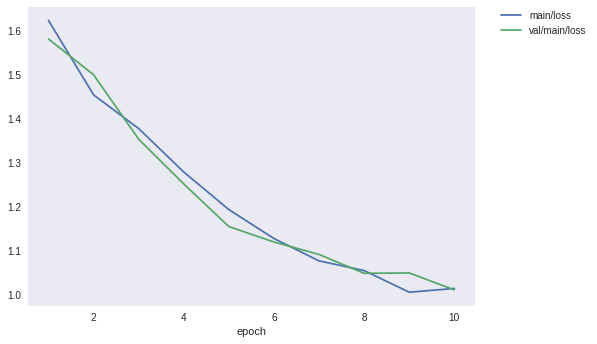

In [14]:
from IPython.display import Image
Image('results/iris_result1/loss.png')

正解率のグラフも同様に確認します。

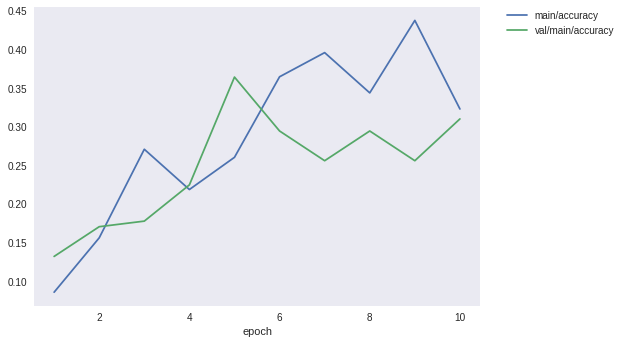

In [15]:
Image('results/iris_result1/accuracy.png')

#### 計算グラフの可視化

`MLP` は自分で書いたネットワーク定義ではありますが、`dump_graph` によって出力された計算グラフのファイルを見てみましょう。Graphviz 形式で保存されています。`pydot` という Python パッケージを使って描画し、PNG 形式でファイルに保存します。

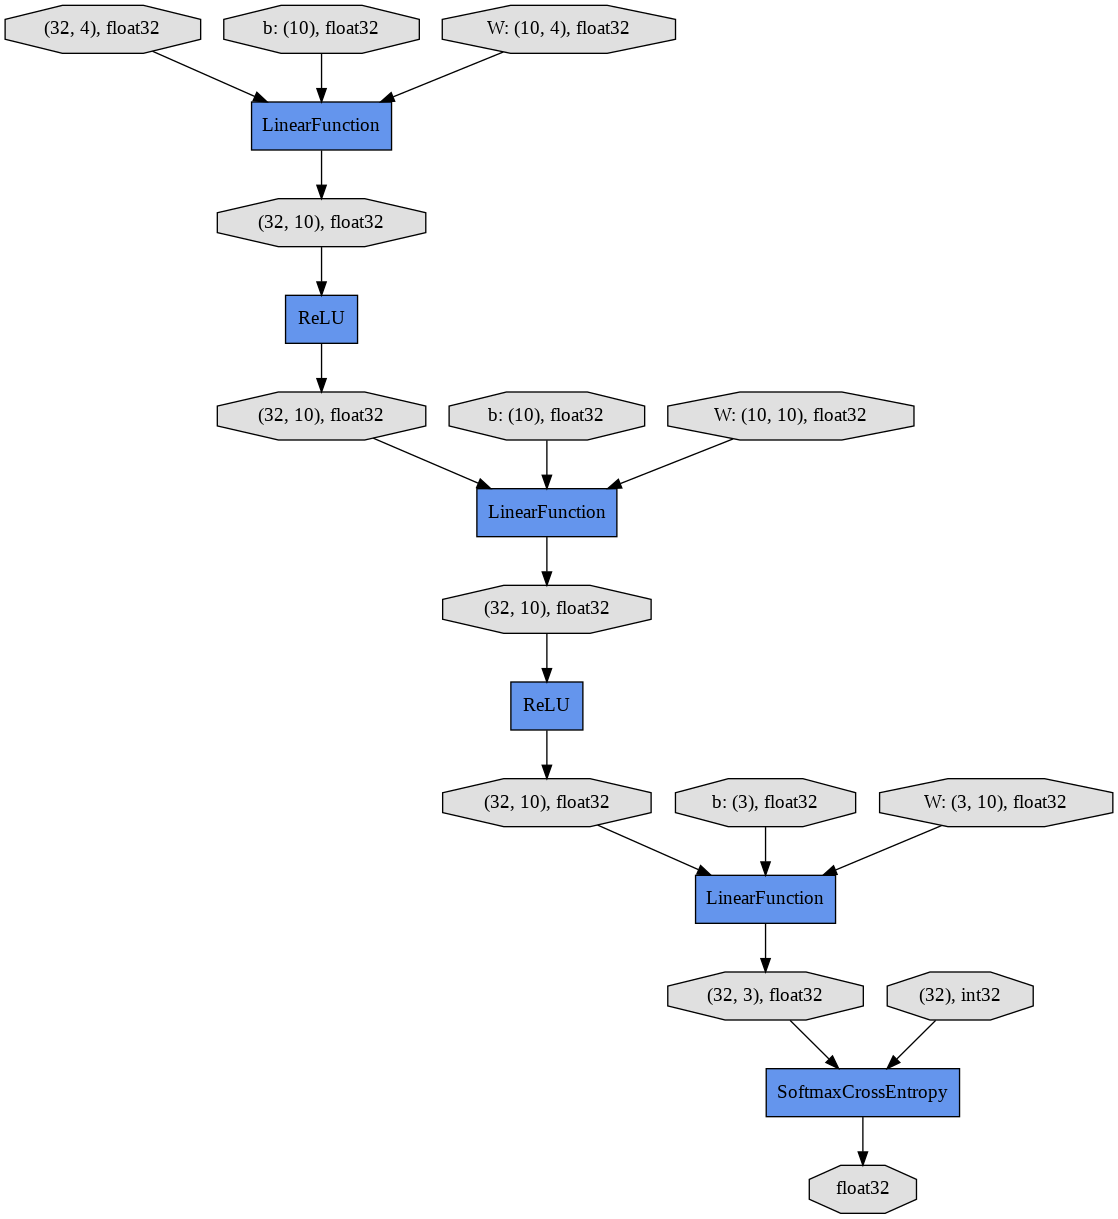

In [16]:
import pydot

file = pydot.graph_from_dot_file('results/iris_result1/cg.dot')
file[0].write_png('graph.png')
Image('graph.png', width=600, height=600)

## `Reporter` で様々な値を表示する

これで、`Trainer` を一通り使うことができるようになりました。実際に訓練中に、どのように損失値や正解率が推移していくかを見ることができるようになりました。たとえば、`PrintReport` を使うとエポック、イテレーション、正解率や損失値を訓練データセットと検証データセットそれぞれについて表示することができます。しかし、それ以外の好きな値を表示したいときは、どうすればよいでしょうか？

また、`PlotReport` や `PrintReport` で表示や保存する対象の値を名前で指定しましたが、その名前はどのようにして決まるのでしょうか？

実際に深層学習のモデルを作成したり開発するときは、モデルの中の値を各イテレーションで表示して値の推移を眺めることによって、そのモデルの内部挙動を把握します。そのために `Trainer` が内部的に保持している仕組みが `Reporter` と観測値（observation）です。`Reporter` の仕組みは[公式ドキュメントで説明されています](https://docs.chainer.org/en/stable/guides/report.html)ので、ここでは簡単な使い方として、`Reporter` で表示する値を追加する例について説明します。本章で作成した `MLP` モデルを少し変更して、途中の値を見られるようにしてみましょう。

In [17]:
from chainer import reporter
class MLP2(chainer.Chain):

    def __init__(self, n_mid_units=10, n_out=3):
        super().__init__()

        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units)
            self.fc2 = L.Linear(n_mid_units, n_mid_units)
            self.fc3 = L.Linear(n_mid_units, n_out)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        reporter.report({'avg_y': F.average(h), 'var_y':F.cross_covariance(h, h)}, self)
        h = self.fc3(h)
        return h

この `MLP2` では、2 層目 `fc2` の出力値に ReLU を適用したあとの値について、それぞれ平均と分散を計算し、 `avg_y` と `var_y` という名前で `Reporter` に登録しています。これだけで、`forward` が呼び出される度に値を `Reporter` に登録するようになります。続いて同様に `Trainer` を作成します。

In [18]:
net = L.Classifier(MLP2())
optimizer = optimizers.SGD(lr=0.01).setup(net)
train_iter = iterators.SerialIterator(train, 32)
updater = training.StandardUpdater(train_iter, optimizer, device=-1) # device=-1でCPUでの計算実行を指定

trainer = training.Trainer(updater, (10, 'epoch'))

次に、 `LogReport` と `PrintReport` を設定します。このとき `LogReport` を設定しないとそもそも値の収集が行われないので、`LogReport` は必須です。 `PrintReport` には、表示したい値を設定します。以下に、それぞれ値を説明します。

- `epoch`、`iteration`、`elapsed_time`: `Trainer` オブジェクトが報告する値で、それぞれエポック数、イテレーション数、経過時間を表します。
- `main` は、オプティマイザが保持するモデル（今回は `L.Classifier`）を表します。階層的に `/` で連結して具体的な統計値を指定します。
- `main/accuracy` は、`L.Classifier` が報告する正解率です。
- `main/loss` は、`L.Classifier` が報告する損失の値です。
- `main/predictor` は、`L.Classifier` に渡されたモデル（今回は `MLP2`）を表します。
- `main/predictor/avg_y` は、`MLP2.forward()` で報告された `avg_y` の値を指します。
- `main/predictor/var_y` は、同様に、`MLP2.forward()` で報告された `var_y` の値を指します。


In [19]:
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport([
    'epoch', 'iteration',
    'main/accuracy',
    'main/predictor/avg_y','main/predictor/var_y',
    'fc2/W/grad/mean']))

`fc2/W/grad/mean` という統計値も一緒に指定しました。
これは、`ParameterStatistics` という拡張機能が報告する値です。


In [20]:
trainer.extend(extensions.ParameterStatistics(
    net.predictor.fc2, {'mean': np.mean}, report_grads=True))

このように `ParameterStatistics` を設定すると、`model.predictor.fc2`（実体は `MLP2` に定義された `L.Linear`）の保持する各パラメータについて、指定した演算（ここでは平均 `np.mean`）を行った結果を報告させることができます。`report_grads=True` と指定することで、逆伝播計算で得られた勾配も対象に含められます。

`fc2/W/grad/mean` は、「パラメータ `fc2/W` の勾配について、`'mean'` をキーにして指定した統計演算を適用した結果」を表しています。

これで準備ができたので、訓練を実行します。

In [21]:
trainer.run()

epoch       iteration   main/accuracy  main/predictor/avg_y  main/predictor/var_y  fc2/W/grad/mean
1           4           0.304688       0.99263               1.56475               0.0462579        
2           7           0.364583       0.890746              1.62918               -0.000847539     
3           10          0.541667       0.921285              1.26662               -0.0109          
4           14          0.6875         0.945301              1.80594               -0.00823223      
5           17          0.697917       0.944931              1.95061               -0.00341311      
6           20          0.645833       0.947953              1.7647                0.000252288      
7           23          0.6875         0.956893              2.48655               -0.00423959      
8           27          0.671875       0.974171              2.08976               0.00225896       
9           30          0.6875         0.95302               2.74338               -0.0047182

実際に `avg_y`、`var_y` が表示されていることがわかります。また、 `ParameterStatistics` で計算した勾配の平均値も表示されています。

## 訓練の早期終了

`Trainer` で訓練ループを実行している途中に、精度（accuracy）の伸びなくなってくることがあります。その場合、さらに訓練を続けても意味が薄いため、自動的に訓練を終了させられると便利です。そのようなテクニックを早期終了（early stopping）といい、Chainer では `EarlyStoppingTrigger` を使います。

他にも、モデルが過学習する前に訓練を止めるといったことにも利用できます。本来であれば、訓練用データセットだけでなく、検証用データセットでも精度が収束するような手法やモデルを利用して過学習を防ぐべきですが、どうしても過学習を防げない（訓練用データセットに対する精度は上がり続けるが、検証用データセットではある点で精度が下がり始める）場合に、検証用データセットでの精度が最も良いタイミングで訓練を止めてモデルを保存し、そのモデルを利用するといったことがあります。

以下では、精度が向上しない場合に強制終了する例を示します。途中までは本章の例と同様ですから、まとめて実行します。

In [22]:
# ネットワークのインスタンス化
np.random.seed(0)
net = L.Classifier(MLP())

from chainer import iterators
batchsize = 32

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(valid, batchsize, False, False)

この例では、学習率を大きめに設定しておきます。そのオプティマイザをアップデータに渡します。

In [23]:
optimizer = optimizers.SGD(lr=0.1).setup(net)
updater = training.StandardUpdater(train_iter, optimizer, device=-1)

早期終了は、`EarlyStoppingTrigger` のインスタンスを `Trainer`のコンストラクタの `stop_trigger` 引数に渡すことで設定します。`EarlyStoppingTrigger` のコンストラクタに渡す引数で、挙動を定義します。

- `monitor` には監視対象の変数を指定します。これは、`Reporter` で報告される値であり、名前も `PrintReport` 等で参照するのと同じものです。あるチェック地点でのこの値の平均値が、それ以前のチェックまでの最良の値よりも悪化していれば動作を停止します。この例では、`Evaluator` による検証データセットに対する損失をチェックします。
- `check_trigger` は、監視対象の変数をチェックするタイミングを指定します。この例では、毎エポックでチェックを行います。
- `max_trigger` は、`Trainer`でのループの最大回数です。トリガーがいつまでも発火しない場合に、ループが永久に続くことを防止します。この例では、最大 30 エポック実行する指定です。
- `patients` は、発火しやすさを整数で指定します。たとえば 3 を指定すると、チェック時にそれまでの最良の値を更新できないことが 3 回続いた場合に終了するという動作になります。

トリガーと `Trainer` の作成は次のようにします。また、結果が上書きされないように、保存先ディレクトリを `result/iris_result5` に変更しています。

In [24]:
from chainer.training.triggers import EarlyStoppingTrigger

trigger = EarlyStoppingTrigger(monitor='val/main/loss', check_trigger=(1, 'epoch'),
                               patients=3, max_trigger=(30, 'epoch'))
trainer = training.Trainer(updater, trigger, out='results/iris_result5')

早期終了の様子をうまく表示できるように拡張機能を設定します。また、検証用データセットに対する精度が監視対象ですから、その検証用データセットに対する精度を毎エポック毎に計算します。

In [25]:
from chainer.training import extensions

trainer.extend(extensions.LogReport(trigger=(1, 'epoch'), log_name='log'))
trainer.extend(extensions.Evaluator(valid_iter, net, device=-1), name='val')
trainer.extend(extensions.PrintReport([
    'epoch', 'main/loss', 'main/accuracy',
    'val/main/loss', 'val/main/accuracy', 'elapsed_time']))

訓練を実行します。

In [26]:
trainer.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           2.50593     0.398438       0.784236       0.74399            0.0188232     
2           0.785771    0.583333       0.679537       0.635817           0.0366072     
3           0.69771     0.635417       0.716272       0.635817           0.0560783     
4           0.610174    0.695312       0.577789       0.635817           0.0757383     
5           0.694001    0.5625         0.493339       0.74399            0.0950976     
6           0.482395    0.75           0.432176       0.783654           0.112379      
7           0.45558     0.864583       0.483449       0.635817           0.127051      
8           0.495235    0.710938       0.84161        0.620192           0.150829      
9           0.60645     0.604167       0.380929       0.876202           0.167282      
10          0.365548    0.90625        0.33407        0.914663           0.183566      
11          0.375977    0.898438  

最大エポック数は 30 を指定していましたが、13 エポック目で停止しました。

このように早期終了を設定することによって、精度向上が滞ったタイミングでうまく訓練を止め、無駄な計算を行わずに済ませることができます。


本章は前章までのニューラルネットワークの実装方法をさらに簡易に、便利にするための方法をお伝えしました。
自身で実装する際にはぜひ活用してみてください。
次章では画像処理の基礎的な内容について解説します。